In [1]:
%matplotlib inline
import os, re
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss
import lightly

from avalanche.models import SimpleCNN

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd
from PIL import Image
import cv2

from datasets.coil100 import Coil100Dataset

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [13]:
root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/ss_learning/ssl_tests/datasets/coil-100'


n_classes = 100
obj_list = np.arange(n_classes)

# obj_list = [5, 7, 4, 18, 22, 26, 68, 75, 90, 99]
# n_classes = len(obj_list)

test_size = 0.98

test_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = obj_list,
                         transform=transforms.ToTensor(), size=64,
                         train=False, test_size=test_size)

feat_ext_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)

100%|██████████| 7200/7200 [00:00<00:00, 1245884.27it/s]


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [15]:
resnet = lightly.models.ResNetGenerator('resnet-9')
feat_ext = nn.Sequential(*list(resnet.children())[:-1],nn.AdaptiveAvgPool2d(1))

# backbone = CoilCNNBackbone(in_channels = 3)

# simpleCNN = SimpleCNN()
# backbone = nn.Sequential(*list(simpleCNN.children())[:-1][0][:-2],nn.AdaptiveAvgPool2d(2))


feat_ext = feat_ext.to(device)

In [16]:
model_name = "core50_simsiam_resnet9"

feat_ext.load_state_dict(torch.load(
        root_dir+"/models/"+model_name+".pth",
        map_location=device))

feat_ext.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, 

In [17]:
from torchvision import models
from torchinfo import summary
# conv_feat_ext = feat_ext[0:6]
conv_feat_ext = feat_ext
conv_feat_ext.eval()
summary(conv_feat_ext, (1,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 1, 1]            --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─Conv2d: 3-3                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 64, 64]           128
│    │    └─Sequential: 3-5              [1, 64, 64, 64]           --
├─Sequential: 1-4                        [1, 128, 32, 32]          --
│    └─BasicBlock: 2-2                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-6                  [1, 128, 32, 32]          73,7

In [18]:
embeddings = []
conv_feat_ext.eval()
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = conv_feat_ext(image).flatten(start_dim=1)
        embeddings.append(emb)
        
embeddings = torch.cat(embeddings, 0)
embeddings = np.array(torch.Tensor.cpu(embeddings))


In [19]:
y_sorted = test_ds.targets
embeddings.shape


(7056, 512)

In [20]:
from sklearn.decomposition import PCA

y = y_sorted.copy()
X = embeddings.copy()

pca = PCA(n_components=100)
pca_result = pca.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9624347686767578


In [21]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto', metric='cosine',
                 init='random', perplexity=10, n_iter=500).fit_transform(pca_result)

[Text(0.5, 1.0, 'Coil-100 data T-SNE projection')]

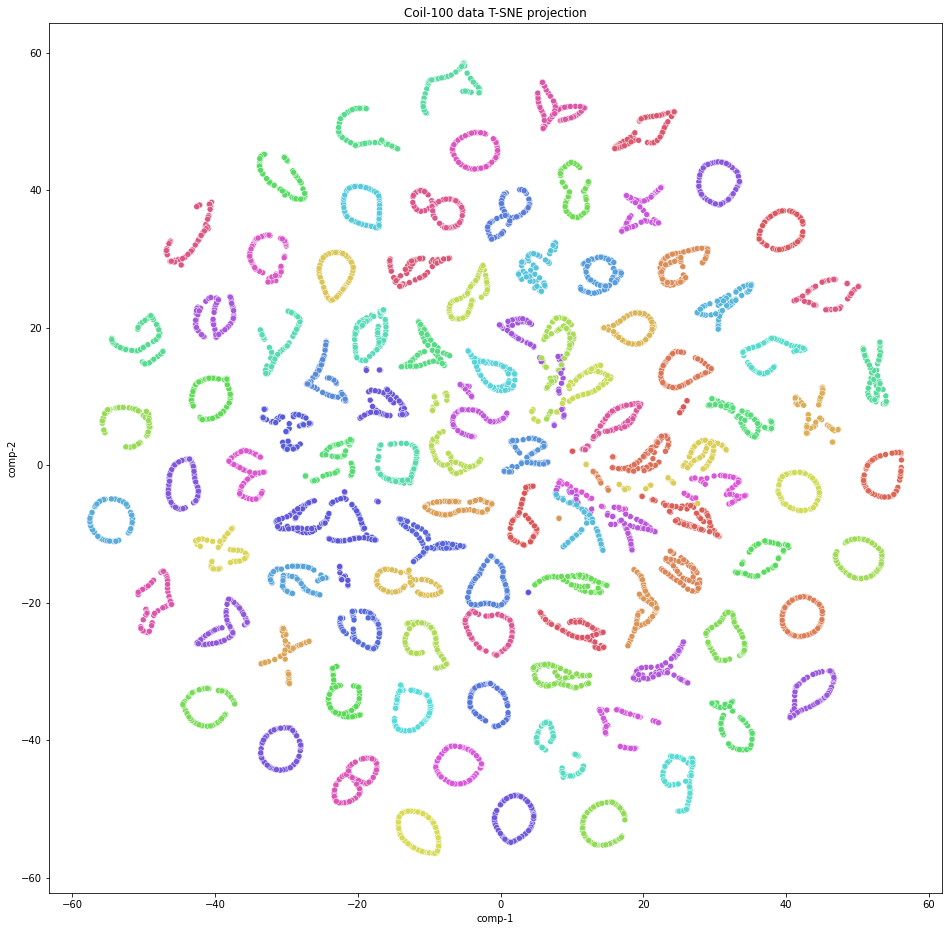

In [23]:
import seaborn as sns
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]
plt.figure(figsize=(16,16))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_classes),legend=False,
                data=df).set(title="Coil-100 data T-SNE projection") 

In [ ]:
import seaborn as sns
y = y_sorted.copy()
fig, axes = plt.subplots(4, 2, figsize=(25,45))
axes=axes.ravel()
df = pd.DataFrame()
df["y"] = y
perp_values = [5,10,15,20,30,45,60,80]
for i, p in enumerate(perp_values):
    X_tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=p, n_iter=5000).fit_transform(pca_result)
    df["comp-1"] = X_tsne[:,0]
    df["comp-2"] = X_tsne[:,1]
    axes[i].set_title("Perplexity="+str(p), fontsize=20)
    plt.sca(axes[i])
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 100),legend=False,
                    data=df)

In [24]:
X = embeddings.copy()
y = y_sorted.copy()

# sparsity_th = 0
# X[np.absolute(X)<sparsity_th]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True) # 80% training and 20% test

In [25]:
n_repeat = 5
bmu_metrics = ["euclidean", "dot_product", "cosine"]
accs = np.zeros(shape=(len(bmu_metrics),n_repeat))
n_neighbors = 1
for bm, bmu_metric in enumerate(bmu_metrics): 
    for r in range(n_repeat):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y, shuffle=True)
        
        if bmu_metric != "dot_product":
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=bmu_metric)
            knn.fit(X_train, y_train)
            y_pred_test=knn.predict(X_test)
            
        else:
            sim_X_train = np.matmul(X_train,X_train.T)
            sim_X_test = np.matmul(X_test,X_train.T)

#             sim_X_train[sim_X_train<dp_min] = dp_min
#             sim_X_train[sim_X_train>dp_max] = dp_max

#             sim_X_test[sim_X_test<dp_min] = dp_min
#             sim_X_test[sim_X_test>dp_max] = dp_max

            sim_X_train = np.max(sim_X_train) - sim_X_train
            sim_X_test = np.max(sim_X_test) - sim_X_test
            
            knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute",  metric="precomputed")
            knn.fit(sim_X_train, y_train)

            y_pred_test=knn.predict(sim_X_test)

        # Model Accuracy: how often is the classifier correct?
        acc = metrics.accuracy_score(y_test, y_pred_test)        
        accs[bm, r] = acc

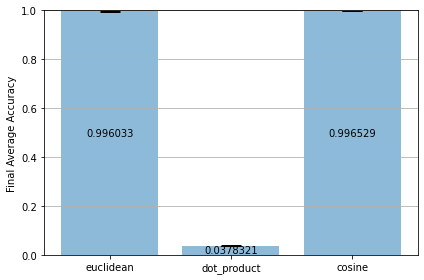

In [26]:
x_pos = np.arange(len(bmu_metrics))
CTEs = np.mean(accs, axis=1)
error = np.std(accs, axis=1)

# Build the plot
fig, ax = plt.subplots()
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Final Average Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(bmu_metrics)
ax.yaxis.grid(True)
ax.set_ylim([0,1])
ax.bar_label(bars, label_type='center')


# Save the figure and show
plt.tight_layout()
plt.show()
# print(CTEs)

In [ ]:
nn = np.arange(1,20,1)
accs_cos = []
accs_euc = []
for i in nn:
    knn = KNeighborsClassifier(n_neighbors=i, metric="cosine")
    knn.fit(X_train, y_train)

    y_pred_test=knn.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred_test)
    accs_cos.append(acc)
    
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)

    y_pred_test=knn.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred_test)
    accs_euc.append(acc)
    # print("Test Accuracy:", acc)

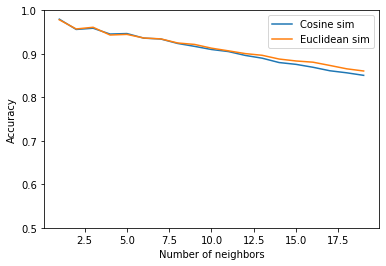

In [34]:
plt.figure()
plt.plot(nn, accs_cos)
plt.plot(nn, accs_euc)
plt.legend(["Cosine sim", "Euclidean sim"])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.ylim([0.5,1])

plt.show()

In [ ]:
clf = svm.LinearSVC(max_iter=2000)
# clf = svm.LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_test))

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5))

emb_magnitudes = np.linalg.norm(embeddings,axis=1)[:,np.newaxis]
mag_mult = np.dot(emb_magnitudes, emb_magnitudes.T)
sparsity = np.count_nonzero(np.absolute(embeddings)<0.02, axis=1)/embeddings.shape[1]

ax1.hist(embeddings[0,:],100)
ax2.hist(emb_magnitudes,100)
ax3.hist(mag_mult.flatten(),100)
ax4.hist(sparsity.flatten(),100)

ax1.set_title("Single Feature Vector Hist", fontsize=10)
ax2.set_title("Feature Vector length Hist", fontsize=10)
ax3.set_title("||x||*||y||", fontsize=10)
ax4.set_title("Sparsitiy Level Hist", fontsize=10)

plt.show()

print("x^2+y^2:  ", 2*np.square(np.mean(emb_magnitudes.flatten())))

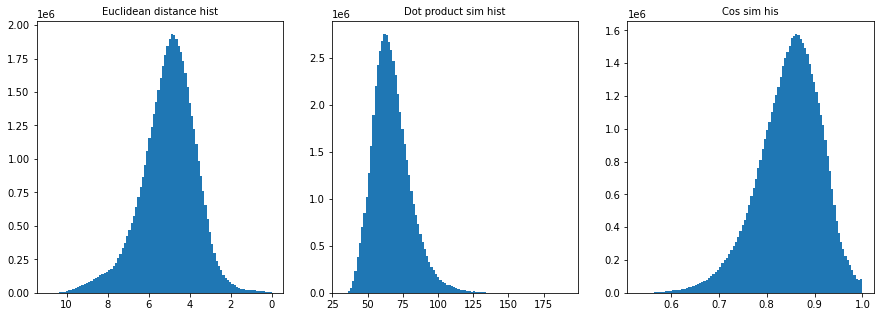

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.hist(dist_matrix.flatten(),100)
ax2.hist(dp_sim.flatten(),100)
ax3.hist(cos_sim.flatten(),100)
ax1.set_title("Euclidean distance hist", fontsize=10)
ax2.set_title("Dot product sim hist", fontsize=10)
ax3.set_title("Cos sim his", fontsize=10)
ax1.set_xlim(ax1.get_xlim()[::-1])
plt.show()

In [19]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

emb_sim = embeddings#[:1440]
sparsity_th = 0
# emb_sim[np.absolute(emb_sim)<sparsity_th]=0
def min_max_scale(data):
    d_min = data.min()
    d_max = data.max()
    return (data-d_min)/(d_max-d_min)

# euclidian distance similarity for population coded data
distances = pdist(emb_sim, metric='euclidean')
dist_matrix = squareform(distances)
# dist_matrix = min_max_scale(dist_matrix)
# euc_sim = 1/np.exp(dist_matrix)


# dot product similarity on u_data_flat_scaled
dp_sim = np.matmul(emb_sim,emb_sim.T)
# dp_sim = min_max_scale(dp_sim)
# dp_max = 8000
# dp_sim[dp_sim<0] = 0
# dp_sim[dp_sim>dp_max] = dp_max

cos_sim = cosine_similarity(emb_sim)

In [23]:
dp_sim = np.matmul(emb_sim,emb_sim.T)
dp_max = 1600
dp_min = 0
dp_sim[dp_sim<dp_min] = dp_min
dp_sim[dp_sim>dp_max] = dp_max

NameError: name 'dp_min' is not defined

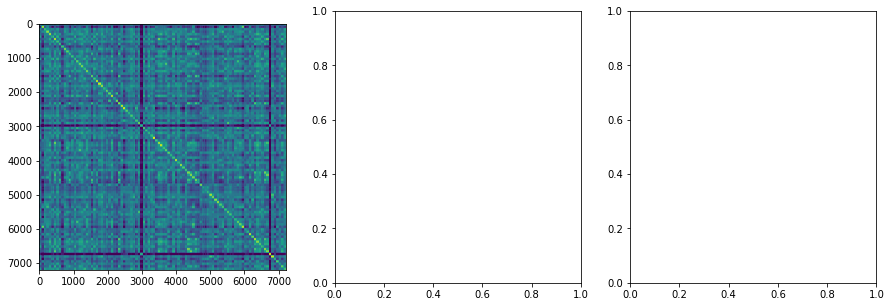

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
im1 = ax1.imshow(-dist_matrix, vmin=-8, vmax=0)
im2 = ax2.imshow(dp_sim, vmin=dp_min, vmax=dp_max)
im3 = ax3.imshow(cos_sim, vmin=0.75, vmax=1)
# im3 = ax3.imshow(u_data_th1_sc)
ax1.set_title("Euclidian Similarity", fontsize=10)
ax2.set_title("Bounded Dot Product", fontsize=10)
ax3.set_title("Cosine similarity", fontsize=10)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.tight_layout()
plt.show()

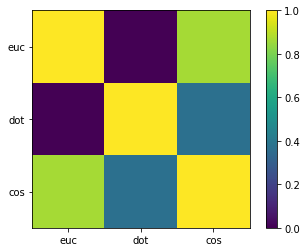

[[ 1.         -0.04082708  0.86503614]
 [-0.04082708  1.          0.37010461]
 [ 0.86503614  0.37010461  1.        ]]


In [21]:
pr_corr = np.corrcoef([-dist_matrix.flatten(), dp_sim.flatten(), cos_sim.flatten()])
fig = plt.figure()
im1 = plt.imshow(pr_corr, vmin=0, vmax=1)
plt.xticks([0,1,2], labels = ["euc", "dot", "cos"])
plt.yticks([0,1,2], labels = ["euc", "dot", "cos"])
fig.colorbar(im1)
plt.show()
print(pr_corr)

In [23]:
dp_max = 1000
dp_min = 0

sim_X_train = np.matmul(X_train,X_train.T)
sim_X_test = np.matmul(X_test,X_train.T)

# sim_X_train[sim_X_train<dp_min] = dp_min
# sim_X_train[sim_X_train>dp_max] = dp_max

# sim_X_test[sim_X_test<dp_min] = dp_min
# sim_X_test[sim_X_test>dp_max] = dp_max

sim_X_train = np.max(sim_X_train) - sim_X_train
sim_X_test = np.max(sim_X_test) - sim_X_test

knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute",  metric="precomputed")
knn.fit(sim_X_train, y_train)

y_pred_test=knn.predict(sim_X_test)

# Model Accuracy: how often is the classifier correct?
acc = metrics.accuracy_score(y_test, y_pred_test)  
print(acc)

0.9524305555555556


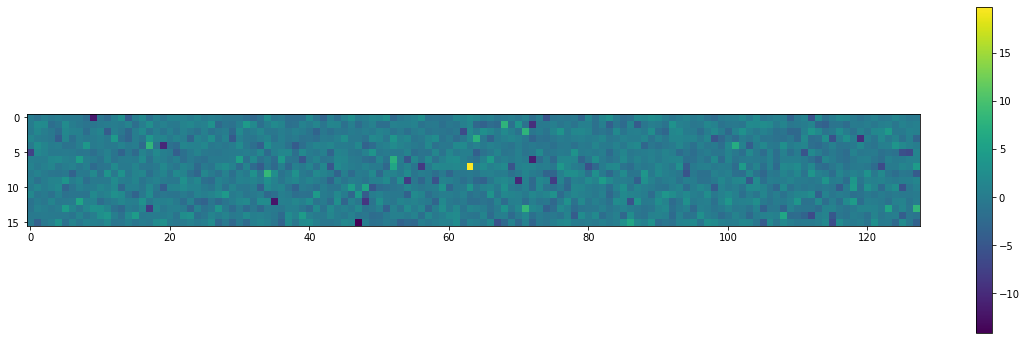

In [193]:
emb_sample = embeddings[0,:].copy()
emb_sample[np.absolute(emb_sample)<0.01] = 0
emb_sample = emb_sample.reshape(16,128)
fig = plt.figure(figsize=(20,6))
im1 = plt.imshow(emb_sample)
fig.colorbar(im1)
plt.show()